In [1]:
!pip install pandas

You should consider upgrading via the '/Users/sherlockieee/.pyenv/versions/3.9.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model


years = range(2011, 2017)
files = [f'https://raw.githubusercontent.com/hueyning/cs156-ml/master/CS156%20Session%206.2%20-%20Linear%20parameter%20models/yosemite-temperatures/yosemite_village/CRNS0101-05-{y}-CA_Yosemite_Village_12_W.txt'for y in years]
usecols = [1, 2, 8] #Date, time, temperature

data = [pd.read_fwf(f, usecols=usecols, header=None ) for f in files]
data = pd.concat(data, ignore_index = True, axis=0)
data.columns = ["Date", "Time", "Temperature"]
data.head

<bound method NDFrame.head of             Date  Time  Temperature
0       20110101     5         -6.4
1       20110101    10         -6.5
2       20110101    15         -6.5
3       20110101    20         -6.5
4       20110101    25         -6.7
...          ...   ...          ...
631291  20161231  2340          0.3
631292  20161231  2345          0.2
631293  20161231  2350          0.0
631294  20161231  2355         -0.1
631295  20170101     0         -0.1

[631296 rows x 3 columns]>

In [3]:
#checking for data type
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631296 entries, 0 to 631295
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         631296 non-null  int64  
 1   Time         631296 non-null  int64  
 2   Temperature  631296 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 14.4 MB


There's no null values and all the value are of the same type, so no preprocessing is needed.

Converting Date column to day of year:

In [4]:
#Converting Date column to day of year
day_of_year = pd.to_datetime(data['Date'].apply(str)).dt.dayofyear
print(day_of_year)
print(set(day_of_year) == set([i for i in range(1, 367)]))

0           1
1           1
2           1
3           1
4           1
         ... 
631291    366
631292    366
631293    366
631294    366
631295      1
Name: Date, Length: 631296, dtype: int64
True


In [5]:
# Converting Time column to minutes of day
def get_minutes(time):
    time = str(time)
    while len(time) < 4:
        time = '0' + time
    minutes = int(time[:2]) * 60 + int(time[2:4])
    return minutes

minutes_of_day = data['Time'].map(get_minutes)
print(minutes_of_day)
assert (set(minutes_of_day).issubset(set([i for i in range(0, 60 * 24)])))

0            5
1           10
2           15
3           20
4           25
          ... 
631291    1420
631292    1425
631293    1430
631294    1435
631295       0
Name: Time, Length: 631296, dtype: int64


In [6]:
years = data['Date'].apply(str).str[:4].apply(int)
print(years)

0         2011
1         2011
2         2011
3         2011
4         2011
          ... 
631291    2016
631292    2016
631293    2016
631294    2016
631295    2017
Name: Date, Length: 631296, dtype: int64


In [7]:
new_data = pd.DataFrame({"year": years, "days": day_of_year, "minutes": minutes_of_day, "temperature": data["Temperature"]})
new_data.head()


,year,days,minutes,temperature
0,2011,1,5,-6.4
1,2011,1,10,-6.5
2,2011,1,15,-6.5
3,2011,1,20,-6.5
4,2011,1,25,-6.7


In [8]:
new_data.shape

(631296, 4)

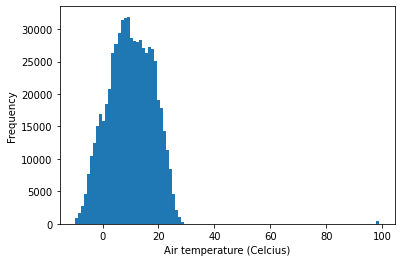

In [9]:
plt.hist(new_data["temperature"], bins = 100)
plt.xlabel("Air temperature (Celcius)")
plt.ylabel("Frequency")
plt.show()

There's some outliers at around 100 degree that needs to be removed since it is impossible for air temperature to get that high. Thus we need to remove the rows.

In [10]:
new_data.drop(new_data[new_data.temperature > 60].index, inplace=True)
new_data.shape

(630854, 4)

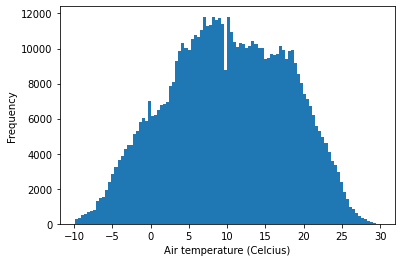

In [11]:
plt.hist(new_data["temperature"], bins = 100)
plt.xlabel("Air temperature (Celcius)")
plt.ylabel("Frequency")
plt.show()

In [12]:
test_data = new_data[new_data.year.isin([2016, 2017])]
training_data = new_data[new_data.year.isin([i for i in range(2011, 2016)])]

assert test_data.shape[0] + training_data.shape[0] == new_data.shape[0]

In [13]:
del data

## Training model with the daily component

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


In [15]:
#trial with arbitary value of sigma, alpha and number of radial basis
sigma = 1000
alpha = 0.01
n_rbf = 400

rbf_centers = np.linspace(0, max(training_data.minutes), n_rbf).reshape(-1, 1)
x_train = np.array(training_data.minutes).reshape(-1, 1)
y_train = np.array(training_data.temperature).reshape(-1, 1)


x = rbf_kernel(x_train, rbf_centers, gamma=1.0 / sigma)


regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(x, y_train)






Ridge(alpha=0.01, fit_intercept=False)

In [16]:
x_test = np.array(test_data.minutes).reshape(-1, 1)
y_test = np.array(test_data.temperature).reshape(-1, 1)

rbf_x_test = rbf_kernel(x_test, rbf_centers, gamma=1/sigma)
y_pred = regr.predict(rbf_x_test)
print(r2_score(y_test, y_pred))

0.044326141547445186


### Testing with different values of alpha

In [17]:
sigma = 1

alpha_vals = [10**i for i in range(-4, 2)]

#using cross validation
regr = Ridge()
alphas = {'alpha': alpha_vals}
clf = GridSearchCV(regr, alphas, cv = 3)
clf.fit(x, y_train)
print(f"The optimal alpha value is {clf.best_params_['alpha']}")


    

The optimal alpha value is 1


In [18]:
y_pred = clf.predict(rbf_x_test)
print(r2_score(y_test, y_pred))

0.0443265972687803


### Testing with different value of sigma

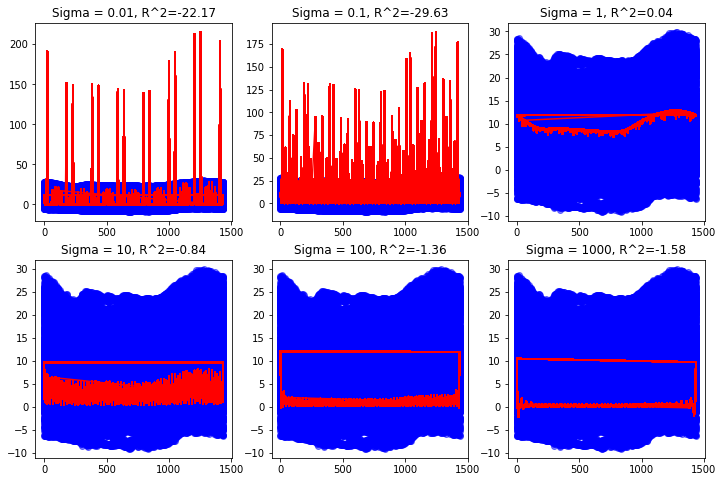

In [19]:
#using optimal alpha value
alpha = clf.best_params_['alpha']
sigma_vals = [10**i for i in range(-2, 4)]
plt.figure(figsize=(12,8))

best_sigma = None
best_r2 = 0

for i, sigma in enumerate(sigma_vals):
    rbf_x_train = rbf_kernel(x_train, rbf_centers, gamma = 1/sigma)
    regr = Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(rbf_x_train, y_train)

    rbf_x_test = rbf_kernel(x_test, rbf_centers)
    y_pred = regr.predict(rbf_x_test)

    plt.subplot(2, 3, i + 1)
    plt.plot(x_test, y_pred, color = 'red')
    plt.scatter(x_test, y_test, color='blue', alpha = 0.5)

    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_sigma = sigma

    plt.title(f"Sigma = {sigma}, R^2={r2:.2f}")

In [20]:
print(best_sigma, best_r2)

1 0.04043400556184151


### Testing with different number of centers

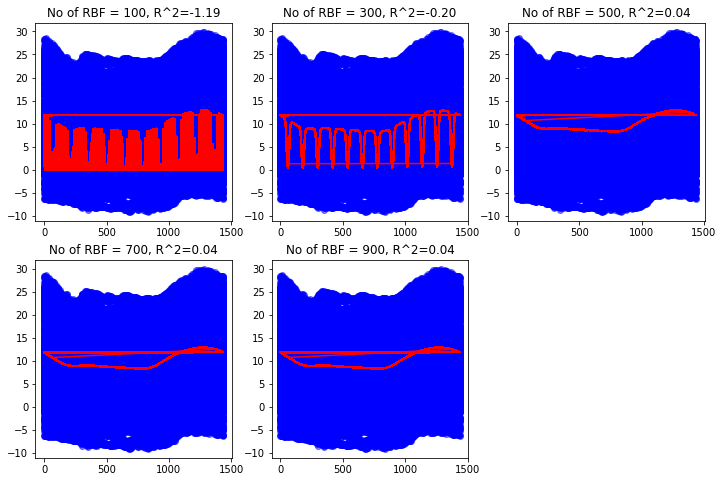

In [21]:
#find best number of rbfs
sigma = best_sigma
rbf_vals = [i for i in range(100, 1000, 200)]
plt.figure(figsize=(12,8))

best_rbf = None
best_r2 = 0

for i, n_rbf in enumerate(rbf_vals):
    rbf_centers = np.linspace(0, max(training_data.minutes), n_rbf).reshape(-1, 1)
    rbf_x_train = rbf_kernel(x_train, rbf_centers, gamma = 1/sigma)
    regr = Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(rbf_x_train, y_train)

    rbf_x_test = rbf_kernel(x_test, rbf_centers)
    y_pred = regr.predict(rbf_x_test)

    plt.subplot(2, 3, i + 1)
    plt.plot(x_test, y_pred, color = 'red')
    plt.scatter(x_test, y_test, color='blue', alpha = 0.5)

    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_rbf = n_rbf

    plt.title(f"No of RBF = {n_rbf}, R^2={r2:.2f}")


In [22]:
print(best_r2, best_rbf)

0.044309640773957715 900


In [23]:
# generating our model based on what we have learnt
alpha = alpha
sigma = best_sigma
n_rbf = best_rbf

rbf_centers = np.linspace(0, max(training_data.minutes), n_rbf).reshape(-1, 1)
rbf_x_train = rbf_kernel(x_train, rbf_centers, gamma = 1/sigma)
regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(rbf_x_train, y_train)


Ridge(alpha=1, fit_intercept=False)

Text(0, 0.5, 'Temperature')

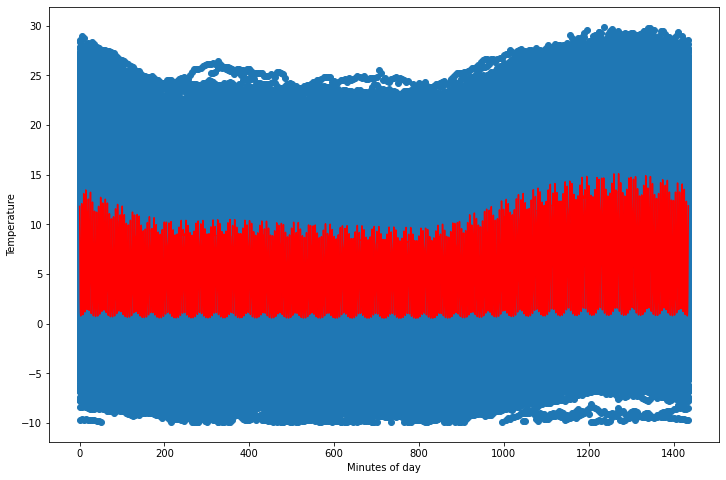

In [24]:
#plotting data

plot_x = np.linspace(0, max(x_train), 10000).reshape(-1, 1)
rbf_plot_x = rbf_kernel(plot_x, rbf_centers)

plot_y = regr.predict(rbf_plot_x)

plt.figure(figsize = (12, 8))
plt.scatter(x_train, y_train)
plt.plot(plot_x, plot_y, color='red')
plt.xlabel('Minutes of day')
plt.ylabel('Temperature')

In [25]:
# testing against new values
rbf_x_test = rbf_kernel(x_test, rbf_centers)
y_pred = regr.predict(rbf_x_test)

print(f"R2 value for time of day linear regression = {r2_score(y_test, y_pred)}")

R2 value for time of day linear regression = 0.044309640773957715


## Training model with the yearly component


In [26]:
#trial with arbitary value of sigma, alpha and number of radial basis
sigma = 1000
alpha = 0.01
n_rbf = 400

rbf_centers = np.linspace(0, max(training_data.days), n_rbf).reshape(-1, 1)
x_train = np.array(training_data.days).reshape(-1, 1)
y_train = np.array(training_data.temperature).reshape(-1, 1)


x = rbf_kernel(x_train, rbf_centers, gamma=1.0 / sigma)


regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(x, y_train)



Ridge(alpha=0.01, fit_intercept=False)

In [27]:
x_test = np.array(test_data.days).reshape(-1, 1)
y_test = np.array(test_data.temperature).reshape(-1, 1)

rbf_x_test = rbf_kernel(x_test, rbf_centers, gamma=1/sigma)
y_pred = regr.predict(rbf_x_test)
print(r2_score(y_test, y_pred))

0.5461544713852737


### Testing with different value of alpha

In [28]:
sigma = 1

alpha_vals = [10**i for i in range(-4, 2)]

#using cross validation
regr = Ridge()
alphas = {'alpha': alpha_vals}
clf = GridSearchCV(regr, alphas, cv = 3)
clf.fit(x, y_train)
print(f"The optimal alpha value is {clf.best_params_['alpha']}")


The optimal alpha value is 10


### Testing with different values of sigma

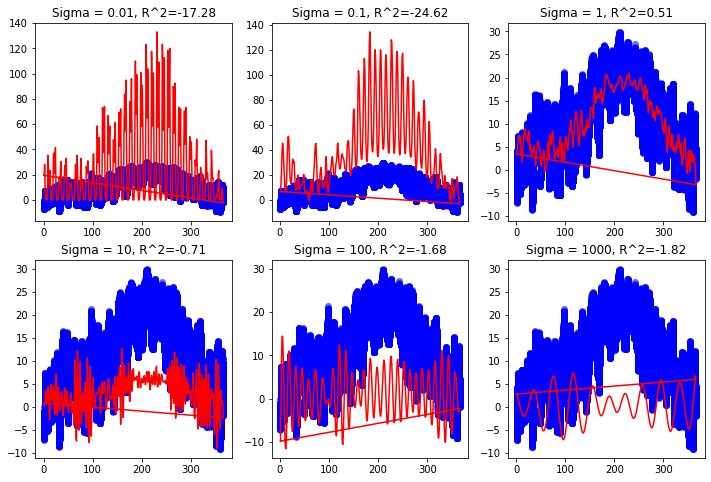

In [29]:
#using optimal alpha value
alpha = clf.best_params_['alpha']
sigma_vals = [10**i for i in range(-2, 4)]
plt.figure(figsize=(12,8))

best_sigma = None
best_r2 = 0

for i, sigma in enumerate(sigma_vals):
    rbf_x_train = rbf_kernel(x_train, rbf_centers, gamma = 1/sigma)
    regr = Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(rbf_x_train, y_train)

    rbf_x_test = rbf_kernel(x_test, rbf_centers)
    y_pred = regr.predict(rbf_x_test)

    plt.subplot(2, 3, i + 1)
    plt.plot(x_test, y_pred, color = 'red')
    plt.scatter(x_test, y_test, color='blue', alpha = 0.5)

    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_sigma = sigma

    plt.title(f"Sigma = {sigma}, R^2={r2:.2f}")

In [30]:
print(best_sigma, best_r2)

1 0.5148934355307633


0.5169626125817456 900


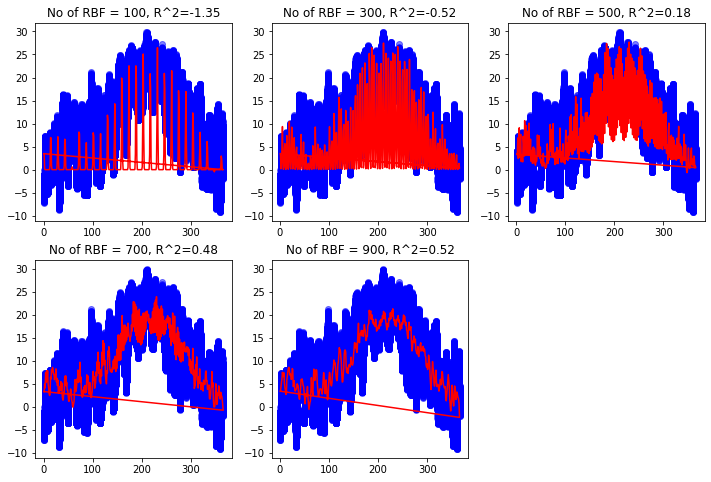

In [31]:
#find best number of rbfs
sigma = best_sigma
rbf_vals = [i for i in range(100, 1000, 200)]
plt.figure(figsize=(12,8))

best_rbf = None
best_r2 = 0

for i, n_rbf in enumerate(rbf_vals):
    rbf_centers = np.linspace(0, max(training_data.minutes), n_rbf).reshape(-1, 1)
    rbf_x_train = rbf_kernel(x_train, rbf_centers, gamma = 1/sigma)
    regr = Ridge(alpha=alpha, fit_intercept=False)
    regr.fit(rbf_x_train, y_train)

    rbf_x_test = rbf_kernel(x_test, rbf_centers)
    y_pred = regr.predict(rbf_x_test)

    plt.subplot(2, 3, i + 1)
    plt.plot(x_test, y_pred, color = 'red')
    plt.scatter(x_test, y_test, color='blue', alpha = 0.5)

    r2 = r2_score(y_test, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_rbf = n_rbf

    plt.title(f"No of RBF = {n_rbf}, R^2={r2:.2f}")

print(best_r2, best_rbf)

In [32]:
# generating our model based on what we have learnt
alpha = alpha
sigma = best_sigma
n_rbf = best_rbf

rbf_centers = np.linspace(0, max(training_data.minutes), n_rbf).reshape(-1, 1)
rbf_x_train = rbf_kernel(x_train, rbf_centers, gamma = 1/sigma)
regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(rbf_x_train, y_train)


Ridge(alpha=10, fit_intercept=False)

Text(0, 0.5, 'Temperature')

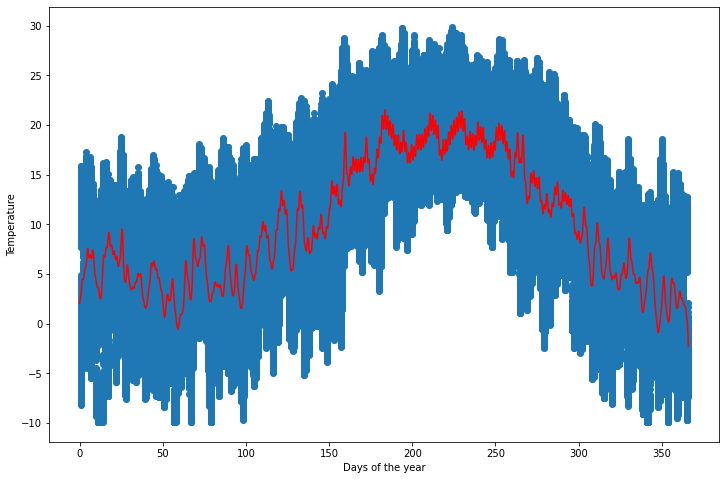

In [33]:
#plotting data

plot_x = np.linspace(0, max(x_train), 10000).reshape(-1, 1)
rbf_plot_x = rbf_kernel(plot_x, rbf_centers)

plot_y = regr.predict(rbf_plot_x)

plt.figure(figsize = (12, 8))
plt.scatter(x_train, y_train)
plt.plot(plot_x, plot_y, color='red')
plt.xlabel('Days of the year')
plt.ylabel('Temperature')

In [34]:
# testing against new values
rbf_x_test = rbf_kernel(x_test, rbf_centers)
y_pred = regr.predict(rbf_x_test)

print(f"R2 value for day of year linear regression = {r2_score(y_test, y_pred)}")

R2 value for day of year linear regression = 0.5169626125817456


## Training with the full model

Since for both the daily component and weekly component has the same sigma value (1) and number of centers (900). For alpha, ideally we would carry out cross validation, but when I tried my computer crashed, so I'm using the middle value between 1 and 10 (5) instead.

In [35]:
n_rbf = 900
sigma = 1
alpha = 5

minutes_centers = np.linspace(0, max(training_data.minutes), n_rbf).reshape(-1, 1)
days_centers = np.linspace(0, max(training_data.days), n_rbf).reshape(-1, 1)

minutes_data = np.array(training_data.minutes).reshape(-1, 1)
days_data = np.array(training_data.days).reshape(-1, 1)

minutes_rbf = rbf_kernel(minutes_data, minutes_centers, gamma=1/sigma)
days_rbf = rbf_kernel(days_data, days_centers, gamma=1/sigma)

rbf_x_train = np.concatenate((minutes_rbf, days_rbf), axis=1)

In [36]:

regr = Ridge(alpha=alpha, fit_intercept=False)
regr.fit(rbf_x_train, y_train)

Ridge(alpha=5, fit_intercept=False)

Text(0, 0.5, 'Temperature')

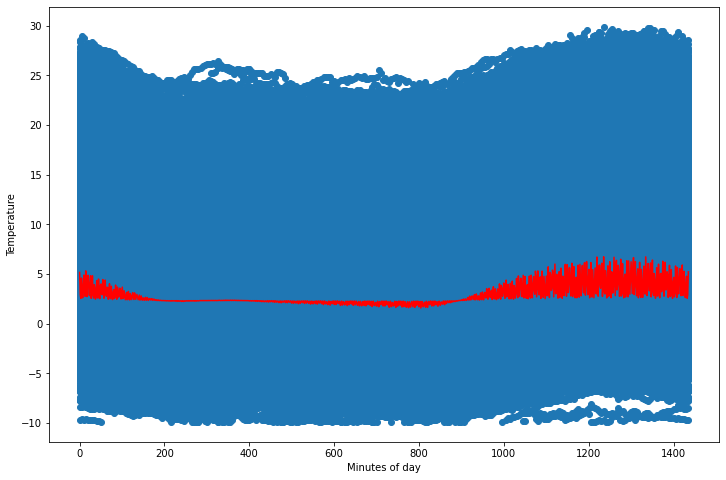

In [37]:
#plotting data for time of day

plot_time = np.linspace(0, max(minutes_data), 1000).reshape(-1, 1)
plot_time_rbf = rbf_kernel(plot_time, minutes_centers, gamma=1/sigma)
#keeping our day of the year constant
plot_day = np.array([1] * len(plot_time)).reshape(-1, 1)
plot_day_rbf = rbf_kernel(plot_day, days_centers, gamma=1/sigma)
rbf_plot_x = np.concatenate((plot_time_rbf, plot_day_rbf), axis=1)

plot_y = regr.predict(rbf_plot_x)

plt.figure(figsize = (12, 8))
plt.scatter(minutes_data, y_train)
plt.plot(plot_time, plot_y, color='red')
plt.xlabel('Minutes of day')
plt.ylabel('Temperature')

Text(0, 0.5, 'Temperature')

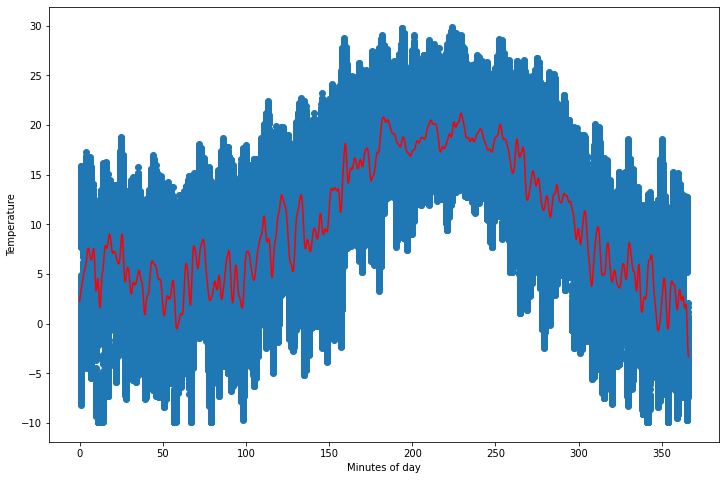

In [38]:
#plotting data for days of the year

plot_day = np.linspace(0, max(days_data), 1000).reshape(-1, 1)
plot_day_rbf = rbf_kernel(plot_day, days_centers, gamma=1/sigma)
#keeping our time of the day constant
plot_minute = np.array([1] * len(plot_day)).reshape(-1, 1)
plot_minute_rbf = rbf_kernel(plot_minute, minutes_centers, gamma=1/sigma)
rbf_plot_x = np.concatenate((plot_minute_rbf, plot_day_rbf), axis=1)

plot_y = regr.predict(rbf_plot_x)

plt.figure(figsize = (12, 8))
plt.scatter(days_data, y_train)
plt.plot(plot_day, plot_y, color='red')
plt.xlabel('Minutes of day')
plt.ylabel('Temperature')

In [39]:
# testing against new values
test_minutes = np.array(test_data.minutes).reshape(-1, 1)
test_days = np.array(test_data.days).reshape(-1, 1)


test_minutes_rbf = rbf_kernel(test_minutes, minutes_centers, gamma=1/sigma)
test_days_rbf = rbf_kernel(test_days, days_centers, gamma=1/sigma)

rbf_x_test = np.concatenate((test_minutes_rbf, test_days_rbf), axis=1)

y_pred = regr.predict(rbf_x_test)

print(f"R2 value for day of year linear regression = {r2_score(y_test, y_pred)}")

R2 value for day of year linear regression = 0.558959797153501
